<a href="https://colab.research.google.com/github/shkwo-n/Leather-Anomaly-Detection-CV/blob/main/MVTEC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import glob
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn
import torchvision
from torchvision import models

import torchvision.utils
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

from torchsummary import summary

import torch.nn.functional as F
import torch.optim as optim
import time
import copy

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Custom Dataset 만들기

#### From Train Folder

In [3]:
root_dir="/content/drive/MyDrive/SW 전문 인재 양성/SW스마트팩토리/개인플젝/mvtec/leather/train/"

In [4]:
train1_file_list = glob.glob(root_dir + "*")

train1_data = []

for class_path in train1_file_list:
    class_name = class_path.split("/")[-1] # extract the class name, e.g.
    # Retrieve each image in their folders (i.e. 0.jpg, 1.jpg, etc.)
    for img_path in glob.glob(class_path + "/*.png"):
        # Check for problematic images
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if type(img) is np.ndarray:
          if img.size == 0:
            continue
        if img is None:
            continue
        train1_data.append([img_path, class_name]) # append image file path to init_data list, and its class name

print(len(train1_data))

245


In [9]:
train1_data[0]

['/content/drive/MyDrive/SW 전문 인재 양성/SW스마트팩토리/개인플젝/mvtec/leather/train/good/000.png',
 'good']

(1024, 1024)

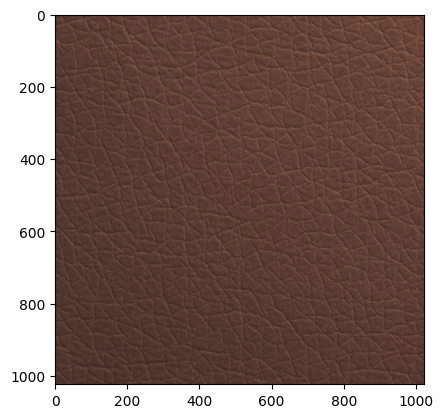

In [6]:
from PIL import Image

img = Image.open('/content/drive/MyDrive/SW 전문 인재 양성/SW스마트팩토리/개인플젝/mvtec/leather/train/good/000.png')
plt.imshow(img)
img.size

In [7]:
img = cv2.imread('/content/drive/MyDrive/SW 전문 인재 양성/SW스마트팩토리/개인플젝/mvtec/leather/train/good/000.png', cv2.IMREAD_COLOR)
img.shape

(1024, 1024, 3)

#### From Test Folder

In [8]:
root_dir = "/content/drive/MyDrive/SW 전문 인재 양성/SW스마트팩토리/개인플젝/mvtec/leather/test/"

# Retrieve the list of ALL folders and files inside the base folder
train2_file_list = glob.glob(root_dir + "*")

train2_data = []
# Create a list that would contain the paths to all the images in the dataset
for class_path in train2_file_list:
    class_name = class_path.split("/")[-1] # extract the class name, e.g.
    # Retrieve each image in their folders (i.e. 0.jpg, 1.jpg, etc.)
    for img_path in glob.glob(class_path + "/*.png"):
        # Check for problematic images
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if type(img) is np.ndarray:
          if img.size == 0:
            continue
        if img is None:
            continue
        train2_data.append([img_path, class_name]) # append image file path to init_data list, and its class name

print(len(train2_data))

124


In [10]:
train_data=[]

train_data.extend(train1_data)
train_data.extend(train2_data)

len(train_data)

369

In [11]:
class CustomData(Dataset):

    def __init__(self, data, transform=None):
        self.data = data
        # Dictionary containing mapping between string and number (class label)
        self.class_map = {"good":0,"color" : 1, "cut": 2,"fold":3, "glue":4, "poke":5}
        # Set image dimensions
        self.img_dim = (1024, 1024)
        # Perform any transformations
        self.transform= transform
        self.normal_transform = transforms.Compose([transforms.ToTensor(),
                                                    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

    def __len__(self):
        return len(self.data)

    # This function is called when an element of this class is accessed via dataset[index]
    def __getitem__(self, index):
        # Get image path and class name
        img_path, class_name = self.data[index] # tuple from __init__()
        # Obtain the image from its path and resize it to the required dimension
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, self.img_dim)
        class_id = self.class_map[class_name] # get the class label, e.g. 0 (for "Dog")
        pil_img=Image.fromarray(img) # convert ndarray to PIL
        # Perform transforms if there are any
        if class_id !=0:
            img_tensor = self.transform(pil_img)
        else:
            img_tensor = self.normal_transform(pil_img)
        # Convert class label to a tensor
        class_id = torch.tensor(class_id)

        return img_tensor, class_id

In [12]:
transform_anomaly=transforms.Compose([transforms.ColorJitter(brightness=0.2, contrast=0.2, hue=0.2),
                                      transforms.RandomHorizontalFlip(p=5),
                                      transforms.RandomVerticalFlip(p=5),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                      ])

transform_normal=transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [13]:
train_size = int(0.8 * len(train_data))
test_size = len(train_data) - train_size
train_set, test_set = torch.utils.data.random_split(train_data, [train_size, test_size])

trainset = CustomData(train_set, transform=transform_anomaly)

testset = CustomData(test_set, transform=transform_normal)

train_loader = DataLoader(trainset, batch_size=24,
                          shuffle=True, num_workers=2, pin_memory=True)

test_loader = DataLoader(testset, batch_size=24,
                          shuffle=False, num_workers=2, pin_memory=True)

##### Augmentation 확인

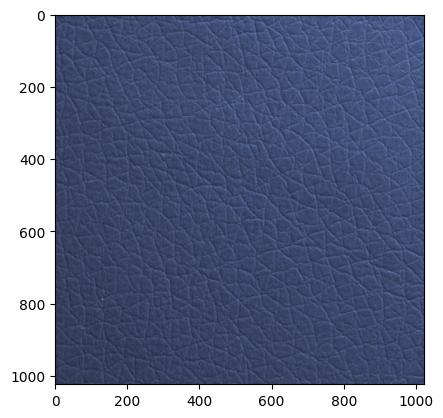

In [14]:
# extract image data
image_data = trainset[0][0]

# normalize image data from 0 to 1
if image_data.min() < 0.0:
    image_data = (image_data + 1.0) / 2.0

plt.imshow(image_data.permute(1, 2, 0))
plt.show()

### Model FineTuning

In [19]:
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.vgg16(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

fc = nn.Sequential(
    nn.Linear(7*7*512, 256), # VGG16 모델의 features의 출력이 7X7, 512장 이기 때문에 in_features=7*7*512 로 설정합니다.
    nn.ReLU(),
    nn.Linear(256, 64),
    nn.ReLU(),
    nn.Linear(64, 6), # Cats vs Dogs 이진 분류이기 때문에 2로 out_features=2로 설정합니다.
)

model.classifier = fc
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0005)

# 손실함수(loss function)을 지정합니다. Multi-Class Classification 이기 때문에 CrossEntropy 손실을 지정하였습니다.
loss_fn = nn.CrossEntropyLoss()

In [16]:
from tqdm import tqdm

def model_train(model, data_loader, loss_fn, optimizer, device):
    # 모델을 훈련모드로 설정합니다. training mode 일 때 Gradient 가 업데이트 됩니다. 반드시 train()으로 모드 변경을 해야 합니다.
    model.train()

    # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
    running_loss = 0
    corr = 0

    # 예쁘게 Progress Bar를 출력하면서 훈련 상태를 모니터링 하기 위하여 tqdm으로 래핑합니다.
    prograss_bar = tqdm(data_loader)

    # mini-batch 학습을 시작합니다.
    for img, lbl in prograss_bar:
        # image, label 데이터를 device에 올립니다.
        img, lbl = img.to(device), lbl.to(device)

        # 누적 Gradient를 초기화 합니다.
        optimizer.zero_grad()

        # Forward Propagation을 진행하여 결과를 얻습니다.
        output = model(img)

        # 손실함수에 output, label 값을 대입하여 손실을 계산합니다.
        loss = loss_fn(output, lbl)

        # 오차역전파(Back Propagation)을 진행하여 미분 값을 계산합니다.
        loss.backward()

        # 계산된 Gradient를 업데이트 합니다.
        optimizer.step()

        # output의 max(dim=1)은 max probability와 max index를 반환합니다.
        # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
        _, pred = output.max(dim=1)

        # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
        # 합계는 corr 변수에 누적합니다.
        corr += pred.eq(lbl).sum().item()

        # loss 값은 1개 배치의 평균 손실(loss) 입니다. img.size(0)은 배치사이즈(batch size) 입니다.
        # loss 와 img.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
        # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
        running_loss += loss.item() * img.size(0)

    # 누적된 정답수를 전체 개수로 나누어 주면 정확도가 산출됩니다.
    acc = corr / len(data_loader.dataset)

    # 평균 손실(loss)과 정확도를 반환합니다.
    # train_loss, train_acc
    return running_loss / len(data_loader.dataset), acc

In [17]:
def model_evaluate(model, data_loader, loss_fn, device):
    # model.eval()은 모델을 평가모드로 설정을 바꾸어 줍니다.
    # dropout과 같은 layer의 역할 변경을 위하여 evaluation 진행시 꼭 필요한 절차 입니다.
    model.eval()

    # Gradient가 업데이트 되는 것을 방지 하기 위하여 반드시 필요합니다.
    with torch.no_grad():
        # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
        corr = 0
        running_loss = 0

        # 배치별 evaluation을 진행합니다.
        for img, lbl in data_loader:
            # device에 데이터를 올립니다.
            img, lbl = img.to(device), lbl.to(device)

            # 모델에 Forward Propagation을 하여 결과를 도출합니다.
            output = model(img)

            # output의 max(dim=1)은 max probability와 max index를 반환합니다.
            # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
            _, pred = output.max(dim=1)

            # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
            # 합계는 corr 변수에 누적합니다.
            corr += torch.sum(pred.eq(lbl)).item()

            # loss 값은 1개 배치의 평균 손실(loss) 입니다. img.size(0)은 배치사이즈(batch size) 입니다.
            # loss 와 img.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
            # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
            running_loss += loss_fn(output, lbl).item() * img.size(0)

        # validation 정확도를 계산합니다.
        # 누적한 정답숫자를 전체 데이터셋의 숫자로 나누어 최종 accuracy를 산출합니다.
        acc = corr / len(data_loader.dataset)

        # 결과를 반환합니다.
        # val_loss, val_acc
        return running_loss / len(data_loader.dataset), acc

In [20]:
num_epochs = 10
model_name = 'vgg16-pretrained'

min_loss = np.inf

# Epoch 별 훈련 및 검증을 수행합니다.
for epoch in range(num_epochs):
    # Model Training
    # 훈련 손실과 정확도를 반환 받습니다.
    train_loss, train_acc = model_train(model, train_loader, loss_fn, optimizer, device)

    # 검증 손실과 검증 정확도를 반환 받습니다.
    val_loss, val_acc = model_evaluate(model, test_loader, loss_fn, device)

    # val_loss 가 개선되었다면 min_loss를 갱신하고 model의 가중치(weights)를 저장합니다.
    if val_loss < min_loss:
        print(f'[INFO] val_loss has been improved from {min_loss:.5f} to {val_loss:.5f}. Saving Model!')
        min_loss = val_loss
        torch.save(model.state_dict(), f'{model_name}.pth')

    # Epoch 별 결과를 출력합니다.
    print(f'epoch {epoch+1:02d}, loss: {train_loss:.5f}, acc: {train_acc:.5f}, val_loss: {val_loss:.5f}, val_accuracy: {val_acc:.5f}')

100%|██████████| 13/13 [00:13<00:00,  1.04s/it]


[INFO] val_loss has been improved from inf to 1.07831. Saving Model!
epoch 01, loss: 1.04770, acc: 0.69492, val_loss: 1.07831, val_accuracy: 0.78378


100%|██████████| 13/13 [00:13<00:00,  1.06s/it]


[INFO] val_loss has been improved from 1.07831 to 0.94883. Saving Model!
epoch 02, loss: 0.63385, acc: 0.74237, val_loss: 0.94883, val_accuracy: 0.78378


100%|██████████| 13/13 [00:13<00:00,  1.08s/it]


epoch 03, loss: 0.49573, acc: 0.76610, val_loss: 1.20214, val_accuracy: 0.78378


100%|██████████| 13/13 [00:13<00:00,  1.06s/it]


epoch 04, loss: 0.44049, acc: 0.82373, val_loss: 1.42479, val_accuracy: 0.78378


100%|██████████| 13/13 [00:14<00:00,  1.08s/it]


epoch 05, loss: 0.41555, acc: 0.82373, val_loss: 1.57893, val_accuracy: 0.78378


100%|██████████| 13/13 [00:13<00:00,  1.06s/it]


epoch 06, loss: 0.38558, acc: 0.86441, val_loss: 1.67437, val_accuracy: 0.78378


100%|██████████| 13/13 [00:13<00:00,  1.03s/it]


epoch 07, loss: 0.38265, acc: 0.84746, val_loss: 1.90616, val_accuracy: 0.78378


100%|██████████| 13/13 [00:13<00:00,  1.05s/it]


epoch 08, loss: 0.35941, acc: 0.88475, val_loss: 1.81759, val_accuracy: 0.78378


100%|██████████| 13/13 [00:13<00:00,  1.06s/it]


epoch 09, loss: 0.32440, acc: 0.89831, val_loss: 1.82899, val_accuracy: 0.78378


100%|██████████| 13/13 [00:13<00:00,  1.01s/it]


epoch 10, loss: 0.29869, acc: 0.89153, val_loss: 2.16974, val_accuracy: 0.78378
